# list of reselected target  and generate sky trajectories and plot

- Author Sylvie Dagoret-Campagne
- Creation : August 29th 2023
- Update : August 30th 2023 : DarkTimeIndex 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from matplotlib.dates import (AutoDateLocator, YearLocator, MonthLocator,
                              DayLocator, WeekdayLocator, HourLocator,
                              MinuteLocator, SecondLocator, MicrosecondLocator,
                              RRuleLocator, rrulewrapper, MONTHLY,
                              MO, TU, WE, TH, FR, SA, SU, DateFormatter,
                              AutoDateFormatter, ConciseDateFormatter)

%matplotlib inline
import pandas as pd

In [2]:
from astropy.coordinates import Longitude,Latitude
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.coordinates import Angle
from astropy.time import Time, TimezoneInfo,TimeDelta

In [3]:
#! pip install --user timezonefinder

In [4]:
import datetime as dt
from datetime import datetime
import timezonefinder, pytz
from calendar import monthrange
import calendar

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
from astroquery.simbad import Simbad

In [7]:
# to view the list of VOTABLE
# Simbad.list_votable_fields()

In [8]:
Simbad.add_votable_fields('sptype')
Simbad.add_votable_fields('flux(U)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(B)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(V)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(R)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(I)') # add the Vega unit Magnitude 
#Simbad.add_votable_fields('flux_unit(V)')
#Simbad.add_votable_fields('flux_unit(I)')
#Simbad.add_votable_fields('flux_system(V)')
#Simbad.add_votable_fields('flux_system(I)')
#Simbad.add_votable_fields('ubv')  # Johnson UBV system

In [9]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [10]:
def CalculateBounds(theta,thetamin,thetamax):
    """
    Handle the boundaries of angles
    
    parameters:
        theta : the input angle in degree to test
        thetamin: lower bound angle
        thetamax: upper bound angle
    """
    
    theta_min_angle = Longitude(thetamin,unit=u.degree)
    theta_max_angle = Longitude(thetamax,unit=u.degree)
    theta_angle = Longitude(theta,unit=u.degree)
    
    
    #print("longitude angles",theta_angle,theta_min_angle,theta_max_angle)
    
    
    wrap = 0
    
    if theta_min_angle.degree < theta_max_angle.degree:
        wrap = 360 * u.deg
    else:
        wrap = 180 * u.deg
        
    theta_min_angle.wrap_angle = wrap
    theta_max_angle.wrap_angle = wrap
    theta_angle.wrap_angle = wrap
       
    #print("wrap",wrap,"theta=",theta_angle,"theta_min=",theta_min_angle,"theta_max",theta_max_angle)
    return theta_angle.is_within_bounds(theta_min_angle,theta_max_angle)
    

# Create the list
    zetSgr 285.65304 -29.880063        V=4.3
    delCap 326.76018 -16.127287       V=2.8
    gamGru 328.482151 -37.364872   V=3.0
    betPsA 337.876377 -32.346075     V=4.3
    alfPsA 344.412692 -29.622237      V=1.2
    nuFor 31.122660 -29.296818        V=4.7
    omeFor 38.46125 -28.232337        V=5.0
    delFor 55.56209 -31.938362          V=5.0
    ups04Eri 64.47359 -33.798349     V=3.6
    alfCol 84.912254 -34.074109         V=2.7
    zetCMa 95.078300 -30.063366      V=3.0
    epsCMa 104.656453 -28.972086   V=1.5

In [11]:
df = pd.read_csv("list_of_stars.txt",sep=" ")

In [12]:
df

,target_name,ra_deg,dec_deg,magV
0,zetSgr,285.653040,-29.880063,4.3
1,delCap,326.760180,-16.127287,2.8
2,gamGru,328.482151,-37.364872,3.0
3,betPsA,337.876377,-32.346075,4.3
4,alfPsA,344.412692,-29.622237,1.2
5,nuFor,31.122660,-29.296818,4.7
6,omeFor,38.461250,-28.232337,5.0
7,delFor,55.562090,-31.938362,5.0
8,ups04Eri,64.473590,-33.798349,3.6
9,alfCol,84.912254,-34.074109,2.7


In [13]:
RA = [ Longitude(ra,unit=u.deg).to_string(unit=u.hour) for ra in df.ra_deg.values ]
df["RA"] = RA

In [14]:
DEC = [ Angle(dec,unit=u.deg).to_string(unit=u.degree) for dec in df.dec_deg.values ]
df["DEC"] = DEC

In [15]:
df

,target_name,ra_deg,dec_deg,magV,RA,DEC
0,zetSgr,285.653040,-29.880063,4.3,19h02m36.7296s,-29d52m48.2268s
1,delCap,326.760180,-16.127287,2.8,21h47m02.4432s,-16d07m38.2332s
2,gamGru,328.482151,-37.364872,3.0,21h53m55.71624s,-37d21m53.5392s
3,betPsA,337.876377,-32.346075,4.3,22h31m30.33048s,-32d20m45.87s
4,alfPsA,344.412692,-29.622237,1.2,22h57m39.04608s,-29d37m20.0532s
5,nuFor,31.122660,-29.296818,4.7,2h04m29.4384s,-29d17m48.5448s
6,omeFor,38.461250,-28.232337,5.0,2h33m50.7s,-28d13m56.4132s
7,delFor,55.562090,-31.938362,5.0,3h42m14.9016s,-31d56m18.1032s
8,ups04Eri,64.473590,-33.798349,3.6,4h17m53.6616s,-33d47m54.0564s
9,alfCol,84.912254,-34.074109,2.7,5h39m38.94096s,-34d04m26.7924s


In [16]:
FLAG_PRESELECTION_TARGET = True
preselected_target_names = np.array(["zetSgr","delCap","gamGru","betPsA","alfPsA","nuFor","omeFor"])

## Calculate the Visibility of the star

### Observation date

In [17]:
NYEAR=2023
NMONTH=9
NDAY=12

### Examples from https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

In [18]:
m33 = SkyCoord.from_name('M33')

In [19]:
bear_mountain = EarthLocation(lat=41.3*u.deg, lon=-74*u.deg, height=390*u.m)
utcoffset = -4*u.hour  # Eastern Daylight Time
time = Time('2023-9-12 23:00:00') - utcoffset

In [20]:
m33altaz = m33.transform_to(AltAz(obstime=time,location=bear_mountain))
print(f"M33's Altitude = {m33altaz.alt:.2}")

M33's Altitude = 4.1e+01 deg


## My Location

In summer the UTC offset at my location is + 2 H

In [21]:
mylat = 48.8534
mylong = 2.3488

In [22]:
paris = EarthLocation(lat=mylat*u.deg, lon=mylong*u.deg, height=0*u.m)
utcoffset = 2*u.hour  # CET
time = Time('2023-9-12 23:00:00') - utcoffset

In [23]:
tf = timezonefinder.TimezoneFinder()
mytimezone_str = tf.certain_timezone_at(lat=mylat, lng=mylong)

In [24]:
mytimezone_str

'Europe/Paris'

In [25]:
if mytimezone_str is None:
    print("Could not determine my time zone")
else:
    # Display the current time in that time zone
    
    
    timezone = pytz.timezone(mytimezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.utcnow()
    timeParis_now = datetime.now(timezone)
    
    print("The UTC Time now %s" % dt)
    print("The actual time in %s is %s" % (mytimezone_str, dt + timezone.utcoffset(dt)))

The UTC Time now 2023-09-06 13:55:08.500564
The actual time in Europe/Paris is 2023-09-06 15:55:08.500564


### For LSST

### Observation location

In [26]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

In [27]:
cerro_pachon = EarthLocation(lat=latitude.degree*u.deg, lon=longitude.degree*u.deg, height=altitude)

### Determination of UTC offset from TimeZone in Chile

In [28]:
tf = timezonefinder.TimezoneFinder()
timezone_str = tf.certain_timezone_at(lat=latitude.degree, lng=longitude.degree)

In [29]:
print(f"Time zone at Rubin LSST Observatory: {timezone_str}")

Time zone at Rubin LSST Observatory: America/Santiago


In [30]:
if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
    timezone = pytz.timezone(timezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.utcnow()
    timeChile_now = datetime.now(timezone)
    
    print("The UTC Time now %s" % dt)
    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

The UTC Time now 2023-09-06 13:55:08.962868
The actual time in America/Santiago is 2023-09-06 10:55:08.962868


In [31]:
utcoffset=timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -3.0  hours


In [32]:
tz_utc_minus_xx_hours = TimezoneInfo(utc_offset=int(utcoffset)*u.hour)
tz_utc_minus_xx_hours

In [33]:
timezone.utcoffset

<bound method DstTzInfo.utcoffset of <DstTzInfo 'America/Santiago' LMT-1 day, 19:17:00 STD>>

### Night of observation

In [34]:
night_obs = datetime(NYEAR, NMONTH, NDAY, 0, 0)
night_obs_midnight= datetime(NYEAR, NMONTH, NDAY, 23, 59,59,tzinfo = tz_utc_minus_xx_hours)

In [35]:
night_obs_str=night_obs.strftime("%Y-%m-%d %H:%M:%S")
print(f"Night of Observation : {night_obs_str}")

Night of Observation : 2023-09-12 00:00:00


In [36]:
night_obs_midnight_str=night_obs_midnight.strftime("%Y-%m-%d %H:%M:%S")
night_obs_midnight_str
print(f"Midnight of Night of Observation : {night_obs_midnight_str}")

Midnight of Night of Observation : 2023-09-12 23:59:59


### Compute UTC and Sideral Time at local midnight

In [37]:
tz_utc = TimezoneInfo() 
print("Local time in Santiago in summer (GMT-4) in summer : ",night_obs_midnight)
print("Time in UTC                               : ",night_obs_midnight.astimezone(tz_utc))

Local time in Santiago in summer (GMT-4) in summer :  2023-09-12 23:59:59-03:00
Time in UTC                               :  2023-09-13 02:59:59+00:00


### Sideral time at LSST site midnight

In [38]:
t_lsst = Time(night_obs_midnight.astimezone(tz_utc), scale='utc',location=lsst_location)
t_sidereal_lsst = t_lsst.sidereal_time('apparent')  
print("Sideral Time at LSST midnight:",t_sidereal_lsst)

Sideral Time at LSST midnight: 21h44m26.87662489s


In [39]:
print("Sideral Time angle at LSST midnight:",Angle(t_sidereal_lsst).to(u.degree))

Sideral Time angle at LSST midnight: 326d06m43.14937338s


In [40]:
print("Sideral Time angle at LSST midnight:",Angle(t_sidereal_lsst).degree)

Sideral Time angle at LSST midnight: 326.11198593705075


In [41]:
# To check
t_lsst_2 = Time('2023-09-13 03:59:59', scale='utc',location=('-70.73668333d', '-30.24074167d'))
t_lsst_2.sidereal_time('apparent') 

<Longitude 22.74353691 hourangle>

## Filter Obervable targets according RA and magnitude and culmination angle

- Select the target which Right-Asccention is +/- 6 hours from the sideral time

- The culmination Hour angle at the meridian must not be less than -6H to + 6H

### Criteria on Margin Angle

- documentation to deal with angles : https://het.as.utexas.edu/HET/Software/Astropy-1.0/coordinates/angles.html

In [42]:
MarginAngle = Angle(6.0,u.hour)
MarginAngle

<Angle 6. hourangle>

In [43]:
#calculate tdege range of RA target to be visible within the MarginAngle
ra_min = Longitude((t_sidereal_lsst - MarginAngle).degree,unit=u.deg)
ra_max = Longitude((t_sidereal_lsst + MarginAngle).degree,unit=u.deg)

In [44]:
ra_min

<Longitude 236.11198594 deg>

In [45]:
ra_max

<Longitude 56.11198594 deg>

In [46]:
ra_min_angle = Longitude(ra_min,u.degree)
ra_max_angle = Longitude(ra_max,u.degree)

In [47]:
#ra_min_angle.wrap_angle = 180 * u.deg
#ra_max_angle.wrap_angle = 180 * u.deg

In [48]:
ra_min_angle.degree

236.11198593705078

In [49]:
ra_max_angle.degree

56.11198593705075

### Criteria on culmination angle

In [50]:
culmin_angle_min = 40

### Criteria on magnitude in V

In [51]:
magLim = 12.

In [52]:
latitude

<Latitude -30.24074167 deg>

In [53]:
all_flag_select = []

# numeric collections
all_ra_angles_deg = []
all_dec_angles_deg = []
all_altmax_angle_deg = []
all_zenithmin_angle_deg = []
all_magV = []

# loop on rach entries in the df table to calculate angles

for index, row in df.iterrows(): 
    target_name = row["target_name"]
    
    
    # compute numeric values for ra-dec
    ra_angle = Longitude(row['ra_deg'],unit = u.deg) 
    #ra_angle.wrap_angle = 180 * u.deg
    
    dec_angle = Angle(row["dec_deg"],unit = u.deg) 
    
    # compute culmination angle
    if latitude.deg >= 0:
        if dec_angle.deg >= latitude.deg:
            zenith_angle =   dec_angle - latitude
        else:
            zenith_angle = latitude - dec_angle
    else:
        if dec_angle.deg < latitude.deg :
            zenith_angle =   latitude - dec_angle 
        else:
            zenith_angle =   dec_angle - latitude 
        
    
    culmination_angle = Angle(90.0, unit = u.deg) - zenith_angle
    
  
    magV = row["magV"]

             
    all_ra_angles_deg.append(ra_angle.degree)
    all_dec_angles_deg.append(dec_angle.degree)
    all_altmax_angle_deg.append(culmination_angle.degree) 
    all_zenithmin_angle_deg.append(zenith_angle.degree )
    all_magV.append(magV)
  
    # test on ra angle
    #flag1 = ra_angle.is_within_bounds(ra_min_angle,ra_max_angle)
    flag1 = CalculateBounds(ra_angle.degree,ra_min_angle.degree,ra_max_angle.degree)
    flag2 = (magV < magLim)
    flag3 = False
    
    # test on culmination angle
    if culmination_angle.degree > culmin_angle_min :
        flag3 = True
        
    
    flag = flag1 & flag2 & flag3
    
    # test on preselected names
    if FLAG_PRESELECTION_TARGET:
        if target_name in preselected_target_names:
          
            if not flag:
                print(f"BE CAREFULL , a rejected target {target_name} is in Pre-Selection list, PLEASE CHECK")
            flag =True
        else:
            if flag:
                print(f"BE CAREFULL , a good target {target_name} is not in Pre-Selection list, PLEASE CHECK")
            flag = False
    
    
    
    if flag:
        print(f"{index}, {target_name}, RA = {ra_angle.hour:.2f} , DEC = {dec_angle.degree:.2f} , RA-MIN-MAX = {ra_min_angle.deg:.1f}-{ra_max_angle.deg:.1f},zenith_angle = {zenith_angle.degree:.2f}  culmination angle = {culmination_angle.degree:.2f} , magV = {magV} , flag_select = {flag}")
   
    all_flag_select.append(flag)                

0, zetSgr, RA = 19.04 , DEC = -29.88 , RA-MIN-MAX = 236.1-56.1,zenith_angle = 0.36  culmination angle = 89.64 , magV = 4.3 , flag_select = True
1, delCap, RA = 21.78 , DEC = -16.13 , RA-MIN-MAX = 236.1-56.1,zenith_angle = 14.11  culmination angle = 75.89 , magV = 2.8 , flag_select = True
2, gamGru, RA = 21.90 , DEC = -37.36 , RA-MIN-MAX = 236.1-56.1,zenith_angle = 7.12  culmination angle = 82.88 , magV = 3.0 , flag_select = True
3, betPsA, RA = 22.53 , DEC = -32.35 , RA-MIN-MAX = 236.1-56.1,zenith_angle = 2.11  culmination angle = 87.89 , magV = 4.3 , flag_select = True
4, alfPsA, RA = 22.96 , DEC = -29.62 , RA-MIN-MAX = 236.1-56.1,zenith_angle = 0.62  culmination angle = 89.38 , magV = 1.2 , flag_select = True
5, nuFor, RA = 2.07 , DEC = -29.30 , RA-MIN-MAX = 236.1-56.1,zenith_angle = 0.94  culmination angle = 89.06 , magV = 4.7 , flag_select = True
6, omeFor, RA = 2.56 , DEC = -28.23 , RA-MIN-MAX = 236.1-56.1,zenith_angle = 2.01  culmination angle = 87.99 , magV = 5.0 , flag_select =

In [54]:
df

,target_name,ra_deg,dec_deg,magV,RA,DEC
0,zetSgr,285.653040,-29.880063,4.3,19h02m36.7296s,-29d52m48.2268s
1,delCap,326.760180,-16.127287,2.8,21h47m02.4432s,-16d07m38.2332s
2,gamGru,328.482151,-37.364872,3.0,21h53m55.71624s,-37d21m53.5392s
3,betPsA,337.876377,-32.346075,4.3,22h31m30.33048s,-32d20m45.87s
4,alfPsA,344.412692,-29.622237,1.2,22h57m39.04608s,-29d37m20.0532s
5,nuFor,31.122660,-29.296818,4.7,2h04m29.4384s,-29d17m48.5448s
6,omeFor,38.461250,-28.232337,5.0,2h33m50.7s,-28d13m56.4132s
7,delFor,55.562090,-31.938362,5.0,3h42m14.9016s,-31d56m18.1032s
8,ups04Eri,64.473590,-33.798349,3.6,4h17m53.6616s,-33d47m54.0564s
9,alfCol,84.912254,-34.074109,2.7,5h39m38.94096s,-34d04m26.7924s


### Test selection

In [55]:
ra_min_angle

<Longitude 236.11198594 deg>

In [56]:
ra_max_angle

<Longitude 56.11198594 deg>

In [57]:
ra_angle= Longitude(31.122660,unit=u.deg)
CalculateBounds(ra_angle.degree,ra_min_angle.degree,ra_max_angle.degree)

True

## Add calculated numerical values to the pandas table

In [58]:
df["ra_deg"] = all_ra_angles_deg
df["dec_deg"] = all_dec_angles_deg 
df["alt_max"] = all_altmax_angle_deg
df["zenith_min"] = all_zenithmin_angle_deg
df["magV"] = all_magV 

## Apply selection cut

In [59]:
df["select"] = all_flag_select
cut = df["select"] == True

t=df[cut]
NTargets=len(t)

In [60]:
t

,target_name,ra_deg,dec_deg,magV,RA,DEC,alt_max,zenith_min,select
0,zetSgr,285.653040,-29.880063,4.3,19h02m36.7296s,-29d52m48.2268s,89.639321,0.360679,True
1,delCap,326.760180,-16.127287,2.8,21h47m02.4432s,-16d07m38.2332s,75.886545,14.113455,True
2,gamGru,328.482151,-37.364872,3.0,21h53m55.71624s,-37d21m53.5392s,82.875870,7.124130,True
3,betPsA,337.876377,-32.346075,4.3,22h31m30.33048s,-32d20m45.87s,87.894667,2.105333,True
4,alfPsA,344.412692,-29.622237,1.2,22h57m39.04608s,-29d37m20.0532s,89.381495,0.618505,True
5,nuFor,31.122660,-29.296818,4.7,2h04m29.4384s,-29d17m48.5448s,89.056076,0.943924,True
6,omeFor,38.461250,-28.232337,5.0,2h33m50.7s,-28d13m56.4132s,87.991595,2.008405,True


### Must reindex the table

In [61]:
t = t.reset_index(drop=True)

In [62]:
t

,target_name,ra_deg,dec_deg,magV,RA,DEC,alt_max,zenith_min,select
0,zetSgr,285.653040,-29.880063,4.3,19h02m36.7296s,-29d52m48.2268s,89.639321,0.360679,True
1,delCap,326.760180,-16.127287,2.8,21h47m02.4432s,-16d07m38.2332s,75.886545,14.113455,True
2,gamGru,328.482151,-37.364872,3.0,21h53m55.71624s,-37d21m53.5392s,82.875870,7.124130,True
3,betPsA,337.876377,-32.346075,4.3,22h31m30.33048s,-32d20m45.87s,87.894667,2.105333,True
4,alfPsA,344.412692,-29.622237,1.2,22h57m39.04608s,-29d37m20.0532s,89.381495,0.618505,True
5,nuFor,31.122660,-29.296818,4.7,2h04m29.4384s,-29d17m48.5448s,89.056076,0.943924,True
6,omeFor,38.461250,-28.232337,5.0,2h33m50.7s,-28d13m56.4132s,87.991595,2.008405,True


In [63]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTargets)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTargets), alpha=1)

## Compute Target location before computing their sky trajectory

In [64]:
all_target_names = t["target_name"]
print("order in selected target location")
print(all_target_names)
#selected_target_locations = [ SkyCoord.from_name(target_name) for target_name in all_target_names]
selected_target_locations = []
for index, row in t.iterrows(): 
    coord = SkyCoord(row['ra_deg'],row['dec_deg'],unit = "deg")
    selected_target_locations.append(coord)

order in selected target location
0    zetSgr
1    delCap
2    gamGru
3    betPsA
4    alfPsA
5     nuFor
6    omeFor
Name: target_name, dtype: object


In [65]:
all_ra_astroquery=[]
all_dec_astroquery=[]
for target_loc in selected_target_locations:
    all_ra_astroquery.append(target_loc.ra)
    all_dec_astroquery.append(target_loc.dec)

## Compute target tag

- the legend in the plot

In [66]:
t

,target_name,ra_deg,dec_deg,magV,RA,DEC,alt_max,zenith_min,select
0,zetSgr,285.653040,-29.880063,4.3,19h02m36.7296s,-29d52m48.2268s,89.639321,0.360679,True
1,delCap,326.760180,-16.127287,2.8,21h47m02.4432s,-16d07m38.2332s,75.886545,14.113455,True
2,gamGru,328.482151,-37.364872,3.0,21h53m55.71624s,-37d21m53.5392s,82.875870,7.124130,True
3,betPsA,337.876377,-32.346075,4.3,22h31m30.33048s,-32d20m45.87s,87.894667,2.105333,True
4,alfPsA,344.412692,-29.622237,1.2,22h57m39.04608s,-29d37m20.0532s,89.381495,0.618505,True
5,nuFor,31.122660,-29.296818,4.7,2h04m29.4384s,-29d17m48.5448s,89.056076,0.943924,True
6,omeFor,38.461250,-28.232337,5.0,2h33m50.7s,-28d13m56.4132s,87.991595,2.008405,True


In [67]:
all_target_simbadnames = t["target_name"]
all_Vmag = []
all_types = []
all_target_tagnames = []
for idx, target_name in enumerate(all_target_simbadnames):
    flag_simbad = False
    try:
        result_table = Simbad.query_object(target_name)
        all_Vmag.append(result_table['FLUX_V'][0])
        all_types.append(result_table['SP_TYPE'][0])
        
        row = t.iloc[idx]
        tagname =  target_name + ", m = " + str(result_table['FLUX_V'][0]) + ", B-V = "+ row["B_V"]  + " (" + result_table['SP_TYPE'][0] +")" 
        flag_simbad = True
    except:
        row = t.iloc[idx]
        tagname = row["target_name"] + ", m= " + str(row["magV"])
    finally:
        
        print(f"{idx}) {target_name} ::{tagname} :: simbad : {flag_simbad}")
        all_target_tagnames.append(tagname)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'zetSgr': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


0) zetSgr ::zetSgr, m= 4.3 :: simbad : False


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'delCap': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


1) delCap ::delCap, m= 2.8 :: simbad : False


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'gamGru': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


2) gamGru ::gamGru, m= 3.0 :: simbad : False


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'betPsA': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


3) betPsA ::betPsA, m= 4.3 :: simbad : False


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'alfPsA': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


4) alfPsA ::alfPsA, m= 1.2 :: simbad : False


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'nuFor': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


5) nuFor ::nuFor, m= 4.7 :: simbad : False
6) omeFor ::omeFor, m= 5.0 :: simbad : False


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'omeFor': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


In [68]:
result_table

In [69]:
all_target_tagnames

['zetSgr, m= 4.3',
 'delCap, m= 2.8',
 'gamGru, m= 3.0',
 'betPsA, m= 4.3',
 'alfPsA, m= 1.2',
 'nuFor, m= 4.7',
 'omeFor, m= 5.0']

In [70]:
t["tag"] = all_target_tagnames

# Astronomical in Observation frame for each selected target

## Initialisation 

In [71]:
midnight_utc = Time(night_obs_midnight_str) - utcoffset*u.hour
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
sideral_times = Angle(t_sidereal_lsst) + Angle(delta_midnight)
times_evening_to_morning = midnight_utc + delta_midnight
frame_evening_to_morning = AltAz(obstime=times_evening_to_morning, location=cerro_pachon)

In [72]:
times_evening_to_morning_datetime = times_evening_to_morning.to_datetime()

## Sun frame

In [73]:
from astropy.coordinates import get_sun
sunaltazs_evening_to_morning = get_sun(times_evening_to_morning).transform_to(frame_evening_to_morning)

## Moon frame

In [74]:
from astropy.coordinates import get_moon
moon_evening_to_morning = get_moon(times_evening_to_morning)
moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

        Use get_body("moon") instead. [warnings]


## Targets Frame

In [75]:
all_target_altazs_evening_to_morning = [target_location.transform_to(frame_evening_to_morning) for target_location in  selected_target_locations ]

## Distance to the moon

In [76]:
all_target_distancetomoon_evening_to_morning = [] 

num_target=0
for idx,targetcoordinateseries in enumerate(all_target_altazs_evening_to_morning): 
    N_coord = len(targetcoordinateseries)
    idx_coord = 0
    all_distances_sep = []
    for idx_coord in range(N_coord):
        distance_sep=targetcoordinateseries[idx_coord].separation(moonaltazs_evening_to_morning[idx_coord])
        all_distances_sep.append(distance_sep.degree)
    all_distances_sep= np.array(all_distances_sep)
    all_distances_sep_min = all_distances_sep.min()
    all_target_distancetomoon_evening_to_morning.append(all_distances_sep_min) 
    all_target_tagnames[idx] += f", d_m = {all_distances_sep_min:.0f}°"
    num_target+=1

In [77]:
all_target_tagnames

['zetSgr, m= 4.3, d_m = 129°',
 'delCap, m= 2.8, d_m = 169°',
 'gamGru, m= 3.0, d_m = 155°',
 'betPsA, m= 4.3, d_m = 162°',
 'alfPsA, m= 1.2, d_m = 161°',
 'nuFor, m= 4.7, d_m = 121°',
 'omeFor, m= 5.0, d_m = 114°']

### Update target tag

In [78]:
t["tag"] = all_target_tagnames

In [79]:
t

,target_name,ra_deg,dec_deg,magV,RA,DEC,alt_max,zenith_min,select,tag
0,zetSgr,285.653040,-29.880063,4.3,19h02m36.7296s,-29d52m48.2268s,89.639321,0.360679,True,"zetSgr, m= 4.3, d_m = 129°"
1,delCap,326.760180,-16.127287,2.8,21h47m02.4432s,-16d07m38.2332s,75.886545,14.113455,True,"delCap, m= 2.8, d_m = 169°"
2,gamGru,328.482151,-37.364872,3.0,21h53m55.71624s,-37d21m53.5392s,82.875870,7.124130,True,"gamGru, m= 3.0, d_m = 155°"
3,betPsA,337.876377,-32.346075,4.3,22h31m30.33048s,-32d20m45.87s,87.894667,2.105333,True,"betPsA, m= 4.3, d_m = 162°"
4,alfPsA,344.412692,-29.622237,1.2,22h57m39.04608s,-29d37m20.0532s,89.381495,0.618505,True,"alfPsA, m= 1.2, d_m = 161°"
5,nuFor,31.122660,-29.296818,4.7,2h04m29.4384s,-29d17m48.5448s,89.056076,0.943924,True,"nuFor, m= 4.7, d_m = 121°"
6,omeFor,38.461250,-28.232337,5.0,2h33m50.7s,-28d13m56.4132s,87.991595,2.008405,True,"omeFor, m= 5.0, d_m = 114°"


## Sort target according increasing max culminating time

In [80]:
all_timemax=np.zeros(NTargets)
all_altitudesmax=np.zeros(NTargets)
for idx in np.arange(NTargets):
    altitudes=all_target_altazs_evening_to_morning[idx].alt
    idx_max=np.where(altitudes==altitudes.max())[0][0]
    all_timemax[idx]=delta_midnight[idx_max].value
    all_altitudesmax[idx]=altitudes.max().degree

In [81]:
all_altitudesmax

array([89.58476491, 75.77637544, 82.98709344, 88.01657126, 89.25394767,
       88.93806872, 87.87917431])

In [82]:
t["tmax"] = all_timemax

In [83]:
all_timemax

array([-2.65465465,  0.06006006,  0.18018018,  0.8048048 ,  1.23723724,
        4.33633634,  4.81681682])

In [84]:
rank = np.argsort(all_timemax)
rank

array([0, 1, 2, 3, 4, 5, 6])

In [85]:
rankinv = np.argsort(rank)
rankinv

array([0, 1, 2, 3, 4, 5, 6])

In [86]:
#t.index[rank]

In [87]:
t["rank_tmax"] = rankinv # rank in time
t["rank_num"] = np.arange(NTargets) # rank in original table

In [88]:
#t = t.sort_values(by = ['tmax'])

### Must reindex dataframe for loop on targets (in sorting order)

In [89]:
#t.reset_index(inplace=True)

In [90]:
t

,target_name,ra_deg,dec_deg,magV,RA,DEC,alt_max,zenith_min,select,tag,tmax,rank_tmax,rank_num
0,zetSgr,285.653040,-29.880063,4.3,19h02m36.7296s,-29d52m48.2268s,89.639321,0.360679,True,"zetSgr, m= 4.3, d_m = 129°",-2.654655,0,0
1,delCap,326.760180,-16.127287,2.8,21h47m02.4432s,-16d07m38.2332s,75.886545,14.113455,True,"delCap, m= 2.8, d_m = 169°",0.060060,1,1
2,gamGru,328.482151,-37.364872,3.0,21h53m55.71624s,-37d21m53.5392s,82.875870,7.124130,True,"gamGru, m= 3.0, d_m = 155°",0.180180,2,2
3,betPsA,337.876377,-32.346075,4.3,22h31m30.33048s,-32d20m45.87s,87.894667,2.105333,True,"betPsA, m= 4.3, d_m = 162°",0.804805,3,3
4,alfPsA,344.412692,-29.622237,1.2,22h57m39.04608s,-29d37m20.0532s,89.381495,0.618505,True,"alfPsA, m= 1.2, d_m = 161°",1.237237,4,4
5,nuFor,31.122660,-29.296818,4.7,2h04m29.4384s,-29d17m48.5448s,89.056076,0.943924,True,"nuFor, m= 4.7, d_m = 121°",4.336336,5,5
6,omeFor,38.461250,-28.232337,5.0,2h33m50.7s,-28d13m56.4132s,87.991595,2.008405,True,"omeFor, m= 5.0, d_m = 114°",4.816817,6,6


# Plot

In [91]:
all_target_names = t["target_name"].values
all_target_names

array(['zetSgr', 'delCap', 'gamGru', 'betPsA', 'alfPsA', 'nuFor',
       'omeFor'], dtype=object)

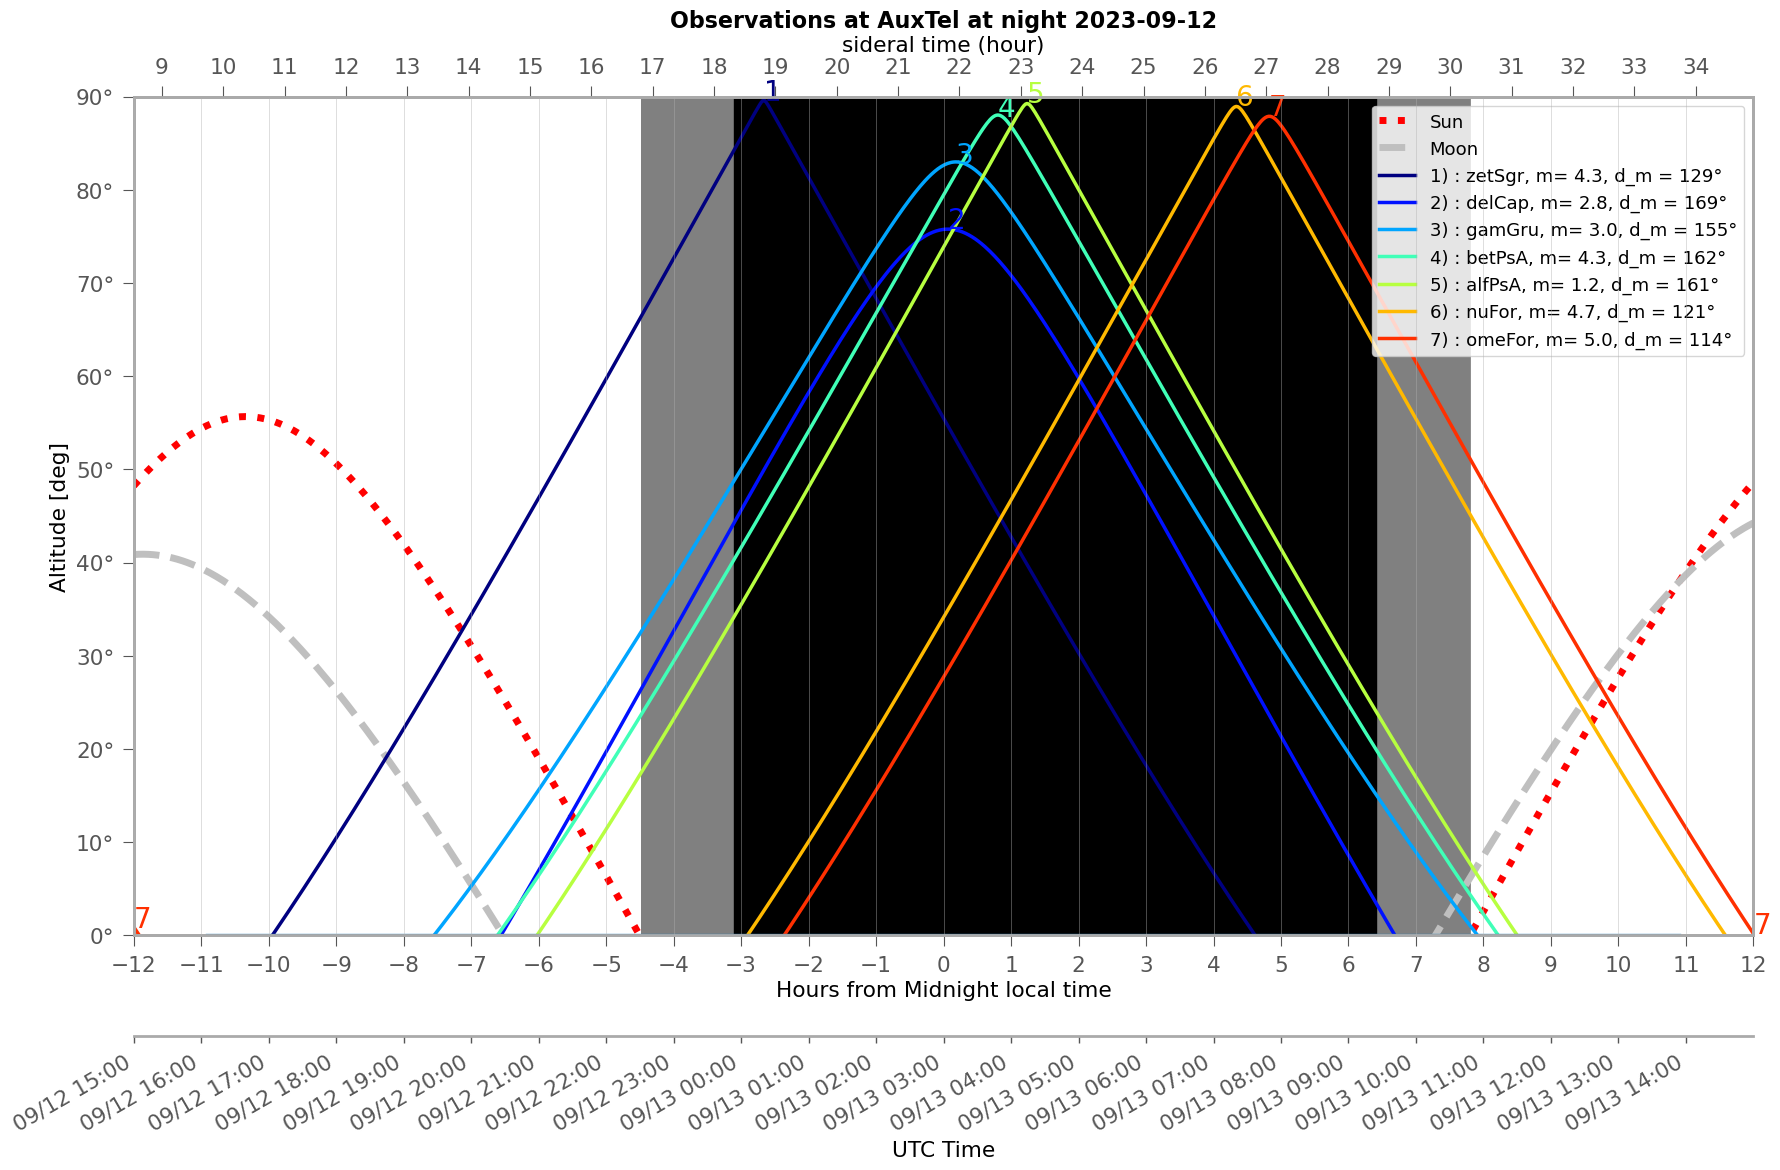

In [92]:
fig = plt.figure(figsize=(18,12))


# First Axis : target sky trajectories
# ====================================
ax=fig.add_subplot(1,1,1)

# plot sun
ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)


# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
  
    # plot trajectory
    ax.plot(delta_midnight, all_target_altazs_evening_to_morning[rank_num].alt,label=label, lw=2.5,color=all_colors[index])

    # plot label
    if all_target_altazs_evening_to_morning[rank_num].alt[-1]>0:
        ax.text(delta_midnight[-1], all_target_altazs_evening_to_morning[rank_num].alt[-1], f'{index+1}',color=all_colors[index],fontsize=20)
    if all_target_altazs_evening_to_morning[rank_num].alt[0]>0:
        ax.text(delta_midnight[0], all_target_altazs_evening_to_morning[rank_num].alt[0], f'{index+1}',color=all_colors[index],fontsize=20)
    if altmax>0 :
        ax.text(tmax, altmax, f'{index+1}',color=all_colors[index],fontsize=20)
    


ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper right')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 90*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('Altitude [deg]')
ax.grid(None)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)
#for label in ax.get_xticklabels(which='major'):
#    label.set(rotation=30, horizontalalignment='right')


# second horizontal axis : Sideral time axis
# ==========================================
ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.grid(None)

# third horizontal axis : UTC time axis
# =====================================

ax3 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.12
ax3.spines["bottom"].set_position(("axes", offset))

ax3.set_frame_on(True)
ax3.patch.set_visible(False) # mandatory
for sp in ax3.spines.values():
    sp.set_visible(False)
ax3.spines["bottom"].set_visible(True)
fmt = '%m/%d %H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))

curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
curvetoremove.remove()
ax3.set_xlim(times_evening_to_morning_datetime[0], times_evening_to_morning_datetime[-1])



ax3.tick_params(which='major', width=1.00, length=5)
ax3.tick_params(which='minor', width=0.75, length=2.5)
ax3.grid(True)
#plt.gcf().autofmt_xdate()  # orient date labels at a slant
# slant for this axis
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax3.set_xlabel("UTC Time")

if FLAG_PRESELECTION_TARGET:
    figname="AuxtelStarAlt_list_of_preselectedstars{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)
else:
    figname="AuxtelStarAlt_list_of_stars{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)
    

plt.tight_layout()
plt.savefig(figname)
plt.show()

# To plot in staralt

https://www.ing.iac.es//Astronomy/telescopes/wht/catformat.html

In [93]:
t_staralt = t[["target_name","RA","DEC","rank_tmax"]]
t_staralt["equinox"] = np.full(NTargets,"J2000")
t_staralt = t_staralt.sort_values(by = ['rank_tmax'])
t_staralt = t_staralt.drop(['rank_tmax'], axis=1)

/tmp/ipykernel_37083/2272969311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_staralt["equinox"] = np.full(NTargets,"J2000")


In [94]:
t_staralt

,target_name,RA,DEC,equinox
0,zetSgr,19h02m36.7296s,-29d52m48.2268s,J2000
1,delCap,21h47m02.4432s,-16d07m38.2332s,J2000
2,gamGru,21h53m55.71624s,-37d21m53.5392s,J2000
3,betPsA,22h31m30.33048s,-32d20m45.87s,J2000
4,alfPsA,22h57m39.04608s,-29d37m20.0532s,J2000
5,nuFor,2h04m29.4384s,-29d17m48.5448s,J2000
6,omeFor,2h33m50.7s,-28d13m56.4132s,J2000


In [95]:
t_staralt.to_csv("staralt.csv",index=False,header=False, sep = " ")

In [96]:
! cat staralt.csv

zetSgr 19h02m36.7296s -29d52m48.2268s J2000
delCap 21h47m02.4432s -16d07m38.2332s J2000
gamGru 21h53m55.71624s -37d21m53.5392s J2000
betPsA 22h31m30.33048s -32d20m45.87s J2000
alfPsA 22h57m39.04608s -29d37m20.0532s J2000
nuFor 2h04m29.4384s -29d17m48.5448s J2000
omeFor 2h33m50.7s -28d13m56.4132s J2000


# Spheric plot

In [97]:
def makePolarPlot(azimuthsInDegrees, zenithAngles, marker=".",ax=None,
                       title=None, color=None, objName=None,lw=0.5):
    if ax==None:
        _ = plt.figure(figsize=(20, 10))
        ax = plt.subplot(111, polar=True)
        
    ax.plot([a*np.pi/180 for a in azimuthsInDegrees], zenithAngles, marker, c=color, label=objName,lw=lw)
    if title:
        ax.set_title(title, va='bottom')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(0, 90)
    return ax

/tmp/ipykernel_37083/4130136354.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])


Text(0.5, 1.0, 'Observations at AuxTel at night 2023-09-12')

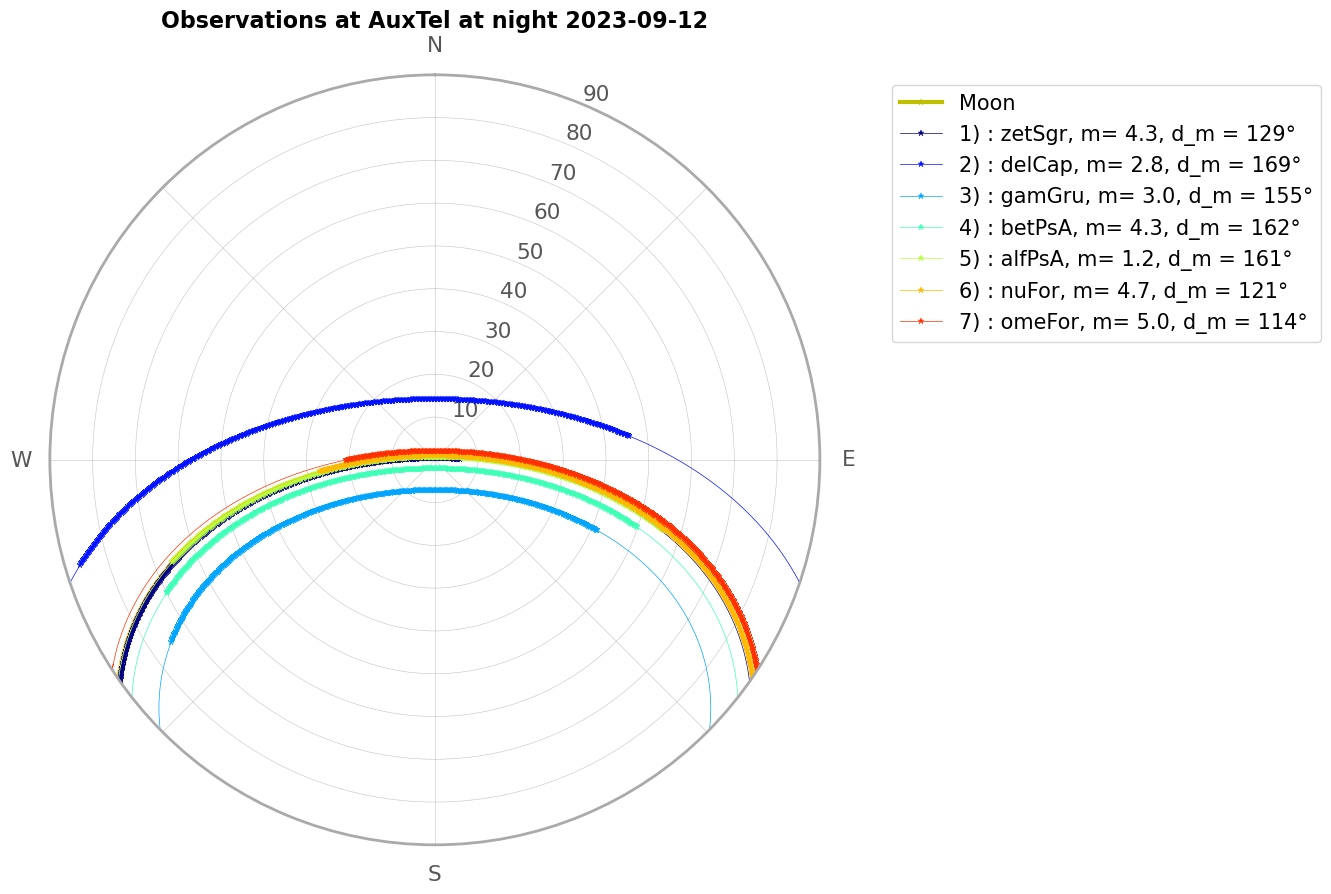

In [98]:
_ = plt.figure(figsize=(20, 10))

ax = plt.subplot(111, polar=True)


darkTimeIndex=[sunaltazs_evening_to_morning.alt < -18*u.deg][0]

# compute zenith and azimuth angles
moon_azimuthsInDegrees = Angle(moonaltazs_evening_to_morning.az).deg
moon_zenithAngles = Angle(moonaltazs_evening_to_morning.zen).deg

#ax=makePolarPlot(moon_azimuthsInDegrees, moon_zenithAngles,ax=ax, marker="--",color="y", title = None, lw=1)

moon_azimuthsInDegreesNight=moon_azimuthsInDegrees[darkTimeIndex]
moon_zenithAnglesNight=moon_zenithAngles[darkTimeIndex]
ax=makePolarPlot(moon_azimuthsInDegreesNight, moon_zenithAnglesNight,ax=ax ,marker="*-",title=None, color = "y",objName="Moon",lw=3)

    
# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
    
    
    
    # compute zenith and azimuth angles
    azimuthsInDegrees=Angle(all_target_altazs_evening_to_morning[rank_num].az).deg
    zenithAngles = Angle(all_target_altazs_evening_to_morning[rank_num].zen).deg
    
    ax=makePolarPlot(azimuthsInDegrees, zenithAngles,ax=ax, marker="-",title=None, color=all_colors[index], lw=0.5)
    
    azimuthsInDegreesNight=azimuthsInDegrees[darkTimeIndex]
    zenithAnglesNight=zenithAngles[darkTimeIndex]
    ax=makePolarPlot(azimuthsInDegreesNight, zenithAnglesNight,ax=ax ,marker="*-",title=None, color=all_colors[index],objName=label,lw=0.5)
    
    thex=zenithAnglesNight[0]*np.sin( (azimuthsInDegreesNight[0]) *np.pi/180.)
    they=zenithAnglesNight[0]*np.cos( (azimuthsInDegreesNight[0])*np.pi/180.)
   
    #plt.text(thex, they,f'{rank}',color=all_colors[rank],fontsize=20)
    
 
ax.legend(bbox_to_anchor=(1.08, 1), prop={'size': 15}, loc='upper left')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)